In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#from AI.Features.Segmenting import deep_segment
#from AI.Features.SegmentingV2 import deep_segment
from AI.Features.SegmentingV8 import deep_segment

#from AI.Features.Segmenting import restore_mask
from AI.Features.SegmentingV8 import restore_mask

from skimage import measure
import glob
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skimage import feature
import os

In [2]:
## Augmentation Function

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
def augm(lst, nm=5):
    # prepare iterator
    ls_gen=[]
    for arr in lst:

        data = arr
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.8,1],
                                     #rotation_range=50,
                                     width_shift_range=[0,.1],
                                     height_shift_range=[0,.1],
                                    #vertical_flip =True,
                                    #horizontal_flip=True
                                    ) 
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot

        for i in range(nm):
            # define subplot
            #pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            ls_gen.append(image)
    return lst+ls_gen

lymph= 40
neut= 60
MONO= 40
BASO= 30
EOSI= 30
[40, 60, 40, 30, 30]
200


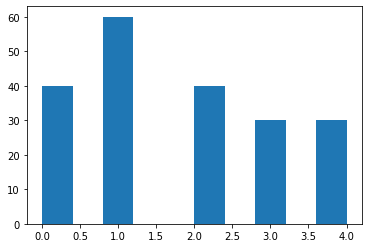

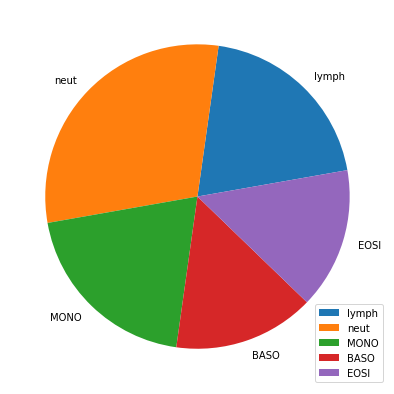

In [4]:
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/LYMPH/*.jpg')]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/NEUT/*.jpg')]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/BASO/*.jpg')]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/EOSI/*.jpg')]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/MONO/*.jpg')]
#MONO=augm(MONO, nm=3)

from random import sample
MONO=sample(MONO,40)


ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


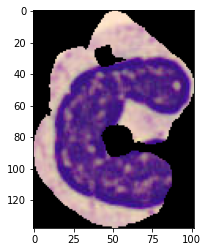

In [6]:
def get_nuc_and_cyt(segmented):
    nuc = (segmented==2).astype('uint8')
    cyt = (segmented==1).astype('uint8')
    #cyt,nuc=restore_mask(segmented)
    return cyt,nuc
     
def mask_cell(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(cyt)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell(neut[15])
plt.imshow(img)
plt.show()

In [7]:
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte
def GLCM(c):
    img =c# io.imread('ff.jpg')

    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    #io.imshow(image)

    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    # GLCM properties
    def contrast_feature(matrix_coocurrence):
        contrast = greycoprops(matrix_coocurrence, 'contrast')
        return "Contrast = ", contrast

    def dissimilarity_feature(matrix_coocurrence):
        dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')    
        return "Dissimilarity = ", dissimilarity

    def homogeneity_feature(matrix_coocurrence):
        homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
        return "Homogeneity = ", homogeneity

    def energy_feature(matrix_coocurrence):
        energy = greycoprops(matrix_coocurrence, 'energy')
        return "Energy = ", energy

    def correlation_feature(matrix_coocurrence):
        correlation = greycoprops(matrix_coocurrence, 'correlation')
        return "Correlation = ", correlation
   
    def ASM_feature(matrix_coocurrence):
        ASM = greycoprops(matrix_coocurrence, 'ASM')
        return "ASM = ", ASM

    
    f1=contrast_feature(matrix_coocurrence)[1][0].tolist()
    f2=dissimilarity_feature(matrix_coocurrence)[1][0].tolist()
    f3=homogeneity_feature(matrix_coocurrence)[1][0].tolist()
    f4=energy_feature(matrix_coocurrence)[1][0].tolist()
    f5=correlation_feature(matrix_coocurrence)[1][0].tolist()
    f6=ASM_feature(matrix_coocurrence)[1][0].tolist()

    return  np.array(f1+f2+f3+f4+f5+f6)
    
GLCM(mask_cell(neut[0]))

array([2.78358036, 3.62879318, 2.46929672, 3.80269608, 0.49837888,
       0.64933473, 0.45828989, 0.66520775, 0.85762514, 0.82226643,
       0.867048  , 0.82100708, 0.45637486, 0.44443447, 0.45826245,
       0.44413686, 0.92887229, 0.90739186, 0.93708685, 0.90294464,
       0.20827801, 0.197522  , 0.21000447, 0.19725755])

# Extent feature

In [9]:

def get_extent(nuc, cyt):
    
    # We only use the nucleus
    extent = measure.regionprops(nuc)[0]['extent']
    
    return extent


def all_together(cell):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    extent = get_extent(nuc,cyt)
    return extent
all_together(neut[15])




0.622269705603039

In [10]:

def get_extent_cyt(nuc, cyt):
    
    # We only use the nucleus
    extent = measure.regionprops(cyt)[0]['extent']
    return extent

def all_together_cyt(cell):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    extent = get_extent_cyt(nuc,cyt)
    return extent


all_together_cyt(neut[15])
#mask_cell(neut[150]).shape

0.25895140664961636

In [11]:
def size1(cell,p):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    if p==0:return nuc.sum()
    if p==1:return cyt.sum()
    if p==2:return cyt.sum()+nuc.sum()
 

def peri(cell,p):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    ar=cyt
    if p==0:ar=nuc
    return measure.perimeter(ar, neighbourhood=8)

peri(MONO[15],1),size1(MONO[10],2)

(948.6213203435597, 23295)

In [12]:
#'eccentricity', 'solidity', 'extent', 'circularity', 'nuc_cyto_ratio', 'size', 'tortuosity'
from skimage import morphology

def eccentricity(im_part):
    if im_part.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(im_part)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,im_part.shape[0]-1,im_part.shape[1]-1)
    
    #tb=measure.regionprops(im_part)[0]['bbox']
    
    xb=abs(tb[1]-tb[3])
    xs=abs(tb[0]-tb[2])
    if xs>xb:
        tm=xb
        xb=xs
        xs=tm
    return np.sqrt(xb**2-xs**2)/xs
    
def Solidity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    """
    print(im_part.sum())
    print(conv.sum())
    plt.imshow(im_part)
    plt.show()
    plt.imshow(conv)
    plt.show()
    """ 
    return im_part.sum()/conv.sum()

def circularity(im_part):
    pr=measure.perimeter(im_part, neighbourhood=8)
    return (pr**2)/(4*np.pi*im_part.sum())

def Convexity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    return measure.perimeter(conv)/measure.perimeter(im_part)

In [13]:
img=neut[13]
segmented = deep_segment(img)
cyt,nuc = get_nuc_and_cyt(segmented)
print(eccentricity(nuc),eccentricity(nuc+cyt))
print(Solidity(nuc),Solidity(nuc+cyt))
print(circularity(nuc),circularity(nuc+cyt))
print(Convexity(nuc),Convexity(nuc+cyt))

1.5788000232998542 0.47620010901206783
0.7875023178193955 0.6373547315993359
3.413615070271242 7.037881524354176
0.8350686494657752 0.6558868232126134


In [14]:
def shape_features(image):
    segmented = deep_segment(image)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    lst=[eccentricity(nuc),eccentricity(all_cyt),Solidity(nuc),Solidity(all_cyt),circularity(nuc),
         circularity(all_cyt),Convexity(nuc),Convexity(all_cyt)]
    lst.append(measure.perimeter(nuc, neighbourhood=8)/n_sum)
    lst.append(measure.perimeter(cyt, neighbourhood=8)/cyt_sum)
    lst.append(n_sum/cyt_sum)
    return np.array(lst)
    
img=neut[12]    
shape_features(img)    

array([1.39532951, 0.66649351, 0.90111154, 0.83830195, 2.08753662,
       5.3095056 , 0.95223293, 0.61824851, 0.07469313, 0.08801599,
       0.48892586])

In [15]:

lymph_extent = [ size1(c,2) for c in lymph]
MONO_extent = [size1(c,2) for c in MONO]

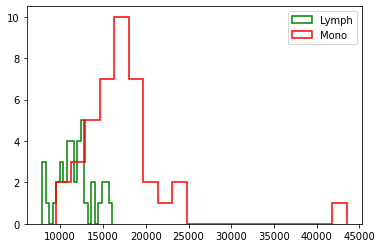

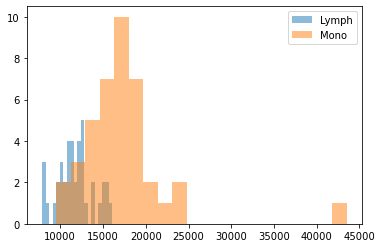

In [16]:


fig, ax = plt.subplots()
ax.hist(lymph_extent, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()
fig, ax = plt.subplots()
ax.hist(lymph_extent, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [19]:
lymph_extent2 = [ size1(c,0) for c in lymph]
MONO_extent2 = [size1(c,0) for c in MONO]

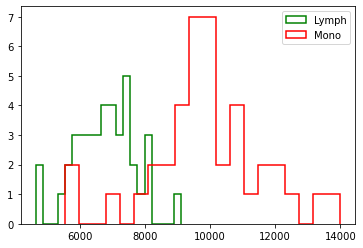

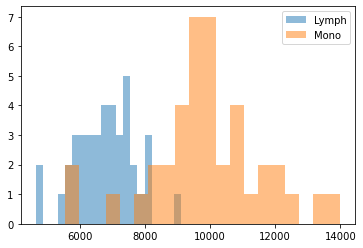

In [20]:
fig, ax = plt.subplots()
ax.hist(lymph_extent2, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent2 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.hist(lymph_extent2, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent2 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [21]:
lymph_extent3 = [ peri(c,1) for c in lymph]
MONO_extent3 = [peri(c,1) for c in MONO]

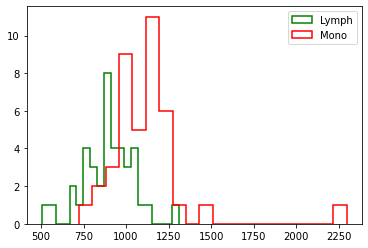

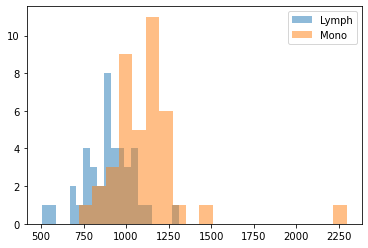

In [22]:
fig, ax = plt.subplots()
ax.hist(lymph_extent3, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent3 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.hist(lymph_extent3, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent3 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [23]:
lymph_extent4 = [ peri(c,0) for c in lymph]
MONO_extent4 = [peri(c,0) for c in MONO]

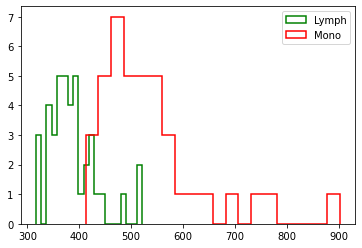

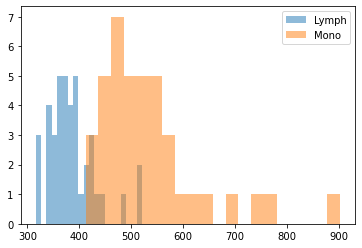

In [24]:
fig, ax = plt.subplots()
ax.hist(lymph_extent4, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent4 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.hist(lymph_extent4, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent4 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [25]:
def circularity2(c,p):
    segmented = deep_segment(c)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    if p==0:return circularity(nuc)
    if p==1:return circularity(all_cyt)

In [26]:
def Solidity2(c,p):
    segmented = deep_segment(c)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    if p==0: return Solidity(nuc)
    if p==1: return Solidity(all_cyt)

In [30]:
def Convexity2(c,p):
    segmented = deep_segment(c)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    if p==0: return Convexity(nuc)
    if p==1: return Convexity(all_cyt)


In [31]:
lymph_extent6 = [ circularity2(c,1) for c in lymph]
MONO_extent6 = [circularity2(c,1) for c in MONO]

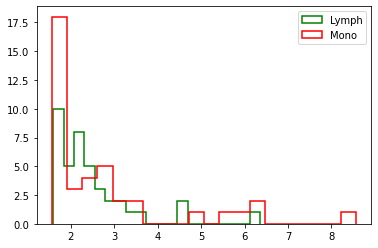

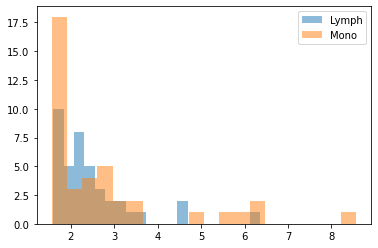

In [32]:
fig, ax = plt.subplots()
ax.hist(lymph_extent6, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent6 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()
fig, ax = plt.subplots()
ax.hist(lymph_extent6, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent6 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [33]:
lymph_extent7 = [ Solidity2(c,1) for c in lymph]
MONO_extent7 = [Solidity2(c,1) for c in MONO]

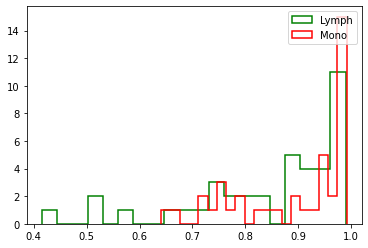

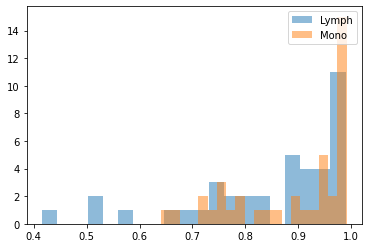

In [34]:
fig, ax = plt.subplots()
ax.hist(lymph_extent7, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent7 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.hist(lymph_extent7, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent7 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()

In [35]:
lymph_extent8 = [ Convexity2(c,1) for c in lymph]
MONO_extent8 = [Convexity2(c,1) for c in MONO]

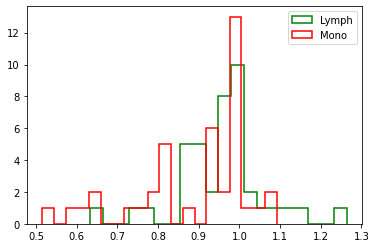

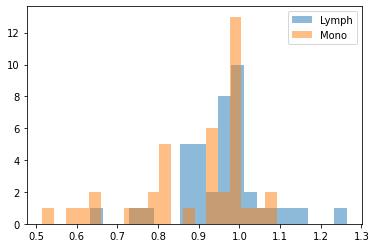

In [36]:
fig, ax = plt.subplots()
ax.hist(lymph_extent8, 20,  None, ec='green', fc='none', lw=1.5, histtype='step', label='Lymph' )
ax.hist(MONO_extent8 , 20,None, ec='red', fc='none', lw=1.5, histtype='step',label='Mono' )
ax.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots()
ax.hist(lymph_extent8, 20, alpha=0.5, label='Lymph' )
ax.hist(MONO_extent8 , 20,alpha=0.5,label='Mono' )
ax.legend(loc='upper right')

plt.show()